# Setup

In [10]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [11]:
from sparse_field_lib import load_data

In [12]:
import matplotlib.pyplot as plt
import sklearn
import torch

from bliss.datasets import sdss
from bliss.models import encoder, decoder
from bliss import sleep

from astropy.table import Table

In [13]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import plotly.express as px
import plotly.graph_objects as go

In [14]:
# where is the sdss data? 
sdss_dir = '/home/imendoza/bliss/data/sdss/'

In [15]:
# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

5


# Metrics

In [48]:
# precision and recall and matrix
from sklearn.metrics import confusion_matrix

def get_aggregate_metrics(keep_match, true_is_gal, pred_is_gal, true_n_total, n_unmatched=0):
    

    tp = sum(keep_match) # true positives = # of objects matched with a true object. 
    fp = sum(~keep_match) + n_unmatched # false positives = detected object not matched with true object.

    # precision 
    # recall = tp / total # of true objects
    precision = (tp / (tp + fp)).item()
    recall = (tp / true_n_total).item()
    f1 = (2 * precision * recall) / (precision + recall)
    
    ratio_misclassed = sum(true_is_gal != pred_is_gal) / len(pred_is_gal)

    print(f'precision: {precision:.3f}')
    print(f'recall: {recall:.3f}')
    print(f'f1: {f1:.3f}')
    print(f'n_unmatched: {n_unmatched}')
    print(f'percentage misclassed: {ratio_misclassed*100:.2f}%')
    print()
    print(confusion_matrix(true_is_gal, pred_is_gal, labels=[True, False]))


# Load data

In [46]:
frame, fits_file, wcs_list, sdss_data = load_data(sdss_dir=sdss_dir)
coadd_cat = Table(fits_file[:])
frame_fits = Table(sdss_data[0]['po_fits'])
print("# objects detected by photo on frame: ", len(frame_fits))
print("# objects detected by photo on coadd: ", len(fits_file['ra'][:]))
frame = frame[0].numpy()
print(frame.shape)

# objects detected by photo on frame:  999
# objects detected by photo on coadd:  901
(1489, 2048)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '19/09/98' to '1998-09-19''. [astropy.wcs.wcs]


In [18]:
wcs = wcs_list[0]
pt, pr = wcs.all_world2pix(coadd_cat['ra'], coadd_cat['dec'], 0)
pt_frame, pr_frame = wcs.all_world2pix(frame_fits['RA'].reshape(-1), frame_fits['DEC'].reshape(-1), 0)
is_star = coadd_cat['probpsf'].data.astype(bool)
is_saturated = coadd_cat['is_saturated'].data.astype(bool)

# remove all locations that are not inside the image. 
mag_cut = 23.5
keep_frame = (pt > 0) & (pt < frame.shape[1]-1) & (pr > 0) & (pr < frame.shape[0]-1) & (~is_saturated)
keep_mag = (~is_star & ((coadd_cat['devmag_r'] < mag_cut) | (coadd_cat['expmag_r'] < mag_cut))) \
| (is_star & (coadd_cat['psfmag_r']<mag_cut))
keep = keep_frame & keep_mag
pt = pt[keep]
pr = pr[keep]
is_star = is_star[keep]
psf_mag = coadd_cat['psfmag_r'][keep]

keep_frame = (pt_frame > 1) & (pt_frame < frame.shape[1]-1) & (pr_frame > 1) & (pr_frame < frame.shape[0]-1) & (frame_fits['PROB_PSF'][:, 2] > -1)
pt_frame = pt_frame[keep_frame]
pr_frame = pr_frame[keep_frame]
is_star_frame = frame_fits['PROB_PSF'][:, 2][keep_frame].data.astype(bool)

print(len(pt), len(pt_frame))

773 962


In [334]:
# nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'].mean()
# def convert_mag_to_flux(mag):
#     return 10**((22.5 - mag) / 2.5) * nelec_per_nmgy

# expmag = frame_fits['CMODELMAG'][:, 2]
# expmag = expmag[expmag > 0]

# # convert_mag_to_flux(expmag)


# # Bryan min mag: 23 
# # look at matches with coadd, look at the ones that it often matches. Make a single cut based on flux

# Investigate Photo misclassifications on frame

In [335]:
# at what magnitudes/sizes does it start to go wrong? for galaxies AND stars? 
from bliss.metrics import inner_join_locs

plocs = torch.from_numpy(np.hstack((pt.reshape(-1, 1), pr.reshape(-1, 1))))
plocs_frame = torch.from_numpy(np.hstack((pt_frame.reshape(-1, 1), pr_frame.reshape(-1, 1))))
_plocs, _plocs_frame, row_indx, col_indx = inner_join_locs(plocs, plocs_frame)


dist = (_plocs - _plocs_frame).abs().max(1)[0]
dist_match = (dist < 1.).numpy().astype(bool)

_is_galaxy = ~is_star[row_indx][dist_match]
_is_galaxy_frame = ~is_star_frame[col_indx][dist_match]

In [336]:
n_unmatched = max(0, len(plocs_frame) - len(plocs))
get_aggregate_metrics(dist_match, _is_galaxy, _is_galaxy_frame, len(plocs), n_unmatched=n_unmatched)

precision: 0.550
recall: 0.684
f1: 0.610
n_unmatched: 189

[[226  46]
 [ 45 212]]


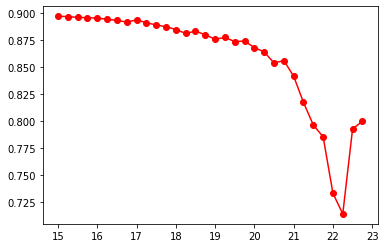

In [278]:
# let's look only at stars
_is_star = is_star[row_indx]
_psf_mag = psf_mag[row_indx]


# create plot of num of matches as a function of magnitude, cutoff detection threshold when 
# we need to bin detections by magnitudes
mags = np.arange(15.0, 23, 0.25)
n_matches_by_mag = np.array([sum(dist_match[_psf_mag > x])/len(dist_match[_psf_mag > x]) for x in mags])
plt.plot(mags, n_matches_by_mag, linestyle='-', marker='o', color='r')

# Prepare model

In [21]:
from bliss.models.binary import BinaryEncoder
from bliss.models.galaxy_encoder import GalaxyEncoder
from bliss.predict import prediction

In [34]:
# prepare BLISS model 
sleep_file = '/home/imendoza/bliss/models/sdss_sleep.ckpt'
galaxy_encoder_file = '/home/imendoza/bliss/models/galaxy_encoder_sdss.ckpt'
binary_file = '/home/imendoza/bliss/models/sdss_binary.ckpt'


# load models
image_encoder= sleep.SleepPhase.load_from_checkpoint(sleep_file).image_encoder.to(device).eval()
galaxy_encoder = GalaxyEncoder.load_from_checkpoint(galaxy_encoder_file).to(device).eval()
binary_encoder = BinaryEncoder.load_from_checkpoint(binary_file).to(device).eval()

# Loop over chunks

In [35]:
import copy

h,w = frame.shape # full frame size.

cp = image_encoder.border_padding # chunk padding 
clen = 300 # chunk slen (square).
cplen = clen + cp*2 # padded chunk slen. 

ihic = h // clen # image height in chunks
iwic = w // clen # image width in chunks

locs = torch.tensor([])
galaxy_bool = torch.tensor([])
prob_galaxy = torch.tensor([])

pt1 = copy.deepcopy(pt)
pr1 = copy.deepcopy(pr)

keep = np.zeros((len(pt1))).astype(bool)

with torch.no_grad():
    for i in range(iwic):
        for j in range(ihic):
            print(i,j)
            x1,y1 = i*clen + cp, j*clen + cp
            pchunk = frame[y1 - cp: y1 + clen + cp, x1 - cp: x1 + clen + cp]
            assert pchunk.shape == (cplen, cplen)
            pchunk = pchunk.astype(np.float32)
            pchunk = torch.from_numpy(pchunk).to(device).reshape(1, 1, cplen, cplen)
            
            # get estimates with BLISS trained model. 
            _, tile_est, est_params = prediction(pchunk, image_encoder, binary_encoder=binary_encoder)
            
            _locs = est_params['locs'].cpu()
            _galaxy_bool = est_params['galaxy_bool'].cpu().reshape(-1, 1)
            _prob_galaxy = est_params['prob_galaxy'].cpu().reshape(-1)
            
            _locs = _locs.reshape(-1, 2)
            x, y = _locs[:, 1].reshape(-1, 1), _locs[:, 0].reshape(-1, 1)
            x = x*clen + x1 - 0.5 
            y = y*clen + y1 - 0.5 # pixels, same format as pt,pr
            locs1 = torch.hstack((x,y)).reshape(-1, 2).cpu()
            locs  = torch.cat((locs, locs1))
            
            _galaxy_bool = _galaxy_bool.reshape(-1, 1)
            galaxy_bool = torch.cat((galaxy_bool, _galaxy_bool))
            
            prob_galaxy = torch.cat((prob_galaxy, _prob_galaxy))
            
            # remove centroids from true photo in padding
            keep1 = (pt1 > x1) & (pt1 < x1+clen) & (pr1 > y1) & (pr1 < y1+clen)
            keep = keep | keep1

            # delete extra stuff in GPU and clear cache for next iteration.
            del pchunk
            del tile_est
            del est_params
            torch.cuda.empty_cache()

pt1, pr1 = pt1[keep], pr1[keep]
is_star1 = is_star[keep]
locs = locs.numpy()
galaxy_bool = galaxy_bool.numpy()
prob_galaxy = prob_galaxy.numpy()

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
5 0
5 1
5 2
5 3


In [36]:
# how many objects are left? 
print(len(pt1), len(locs))

510 458


# Match objects

In [40]:
from bliss.metrics import inner_join_locs

_plocs = torch.from_numpy(np.hstack((pt1.reshape(-1, 1), pr1.reshape(-1, 1))))

_locs = torch.from_numpy(locs)
_galaxy_bool = torch.from_numpy(galaxy_bool)

# do matching
_plocs, _locs, row_indx, col_indx = inner_join_locs(_plocs, _locs)

#only keep match if l_{inf} < 1 pixel away
dist = (_plocs - _locs).abs().max(1)[0]
dist_match = (dist < 1.).numpy().astype(bool)

true_galaxy_bool = ~is_star1[row_indx].reshape(-1).astype(bool)
pred_galaxy_bool = _galaxy_bool[col_indx].reshape(-1).numpy().astype(bool)

_prob_galaxy = prob_galaxy[col_indx].reshape(-1)[dist_match]

In [41]:
# only check classification for objects that matched with a reasonable distance.
true_galaxy_bool = true_galaxy_bool[dist_match]
pred_galaxy_bool = pred_galaxy_bool[dist_match]
misclass = true_galaxy_bool != pred_galaxy_bool

# Results

In [49]:
n_unmatched = max(0, len(locs) - len(pt1))
get_aggregate_metrics(dist_match, true_galaxy_bool, pred_galaxy_bool, len(pt1), n_unmatched=n_unmatched)

precision: 0.725
recall: 0.651
f1: 0.686
n_unmatched: 0
percentage misclassed: 18.67%

[[127  31]
 [ 31 143]]


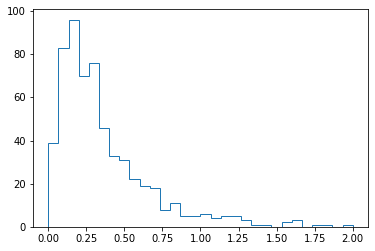

In [296]:
# histogram of mse between matching locations 
%matplotlib inline
plt.hist(dist.numpy(), bins=30, range=(0, 2.0), histtype='step');

ratio misclass with probability between 10%-90%: 0.339


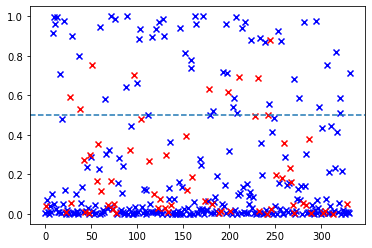

In [297]:
# scatter plot of miscclassification probs
x = np.arange(len(_prob_galaxy))
x1 = x[~misclass]
x2 = x[misclass]
probs_correct = _prob_galaxy[~misclass]
probs_misclass = _prob_galaxy[misclass]
plt.scatter(x1, probs_correct, marker='x', c='b')
plt.scatter(x2, probs_misclass, marker='x', c='r')
plt.axhline(0.5, linestyle='--')

uncertain = (0.2 < _prob_galaxy[misclass]) & (_prob_galaxy[misclass] < 0.8)
r_uncertain = sum(uncertain) / len(_prob_galaxy[misclass])
print(f'ratio misclass with probability between 10%-90%: {r_uncertain:.3f}', )